<h1>Load data</h1>
First of all we need to load data into an arrays
from annotation we load labels for images and boxes. Box are image pixel position x left, x right, y upper, y down, which contains a face.

In [1]:
import pathlib
import os
import matplotlib.pyplot as plt
from natsort import natsorted, ns
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np

path ='archive/annotations'
ls = os.listdir(path)
labels = []
boxs = []
boxsNum = []
#Natsorted is used to sort files with numbers for example {aaa201, aaa100, aaa111} -> {aaa100, aaa111, aaa201}
for f in natsorted(ls, alg=ns.IGNORECASE):
    #ET is used for parse xml file
    mytree = ET.parse(os.path.join(path,f))
    myroot = mytree.getroot()
    counter = 0
    for o in myroot.iter('object'):
        counter+=1
        for n in o.iter('name'):
            labels.append(n.text)
        for d in o.iter('bndbox'):
            box = []
            box.append(d.find("xmin").text)
            box.append(d.find("ymin").text)
            box.append(d.find("xmax").text)
            box.append(d.find("ymax").text)
            boxs.append(box)
    boxsNum.append(counter)

#Get name of labels
label_set = set(labels)
#Change labels to numeric value {0, 1, 2} etc.
labels = np.array(pd.factorize(labels)[0])

<h1>Load images</h1>
Below code loads faces from images into list and preprocessing it.

In [2]:
import cv2

path ='archive/images'
ls = os.listdir(path)
imgs = []
index = 0
box_counter = 0
for index, f in enumerate(natsorted(ls, alg=ns.IGNORECASE)):
    img = os.path.join(path, f)
    im = cv2.imread(img)
    #cv2.imread reads image in BGR colors so we need to change it to RGB
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    for i in range(boxsNum[index]):
        xmin = int(boxs[box_counter][0])
        ymin = int(boxs[box_counter][1])
        xmax = int(boxs[box_counter][2])
        ymax = int(boxs[box_counter][3])
        box_counter+=1
        #cropp face from image which is in given box
        cropped_img = im[ymin:ymax, xmin:xmax]
        dim = (60, 60)
        resized_img = []
        try:
            #resize image to same sizes
            resized_img = cv2.resize(cropped_img, dim, fx=0, fy=0, interpolation = cv2.INTER_CUBIC)
        except Exception as e:
            print(e)
        imgs.append(resized_img)
#change imgs from list to np.array for better preformance and esiest operation on it
imgs = np.array(imgs)

<h1>Split and normalize</h1>


In [3]:
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(imgs, labels, test_size=0.2)
X_train, X_test = X_train/255.0, X_test/255.0

<h1>Visualise data with label</h1>

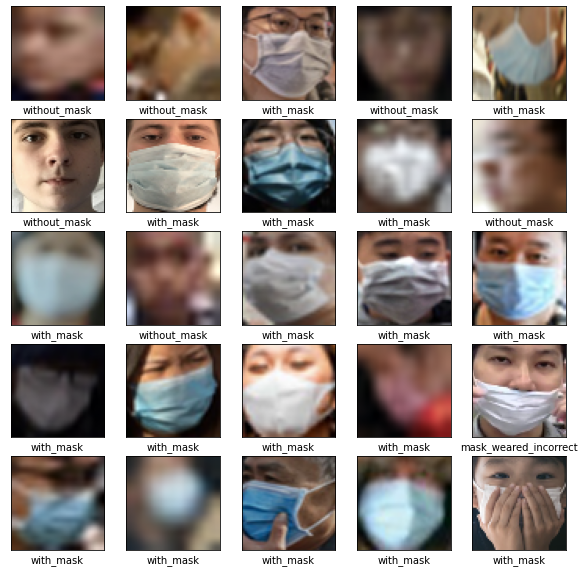

In [4]:
class_names = ['without_mask', 'with_mask', 'mask_weared_incorrect']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[int(y_train[i])])
plt.show()



<h1>Prepare model and train</h1>

In [7]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

model = models.Sequential()
#Warstwa konwolucyjna, w dużym uproszczeniu zawiera różne filtry, które przechodzą po obrazie i w wyniku zwraca przefiltrowane obrazy (3, 3) -> maska filtru (60, 60, 3) -> rozmiar obrazu i liczba kanałów kolorów
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(60, 60, 3)))
#Warstwa łącząca. W skróciue zmienia rozmiar obrazów, Np. max pooling wybiera w masce (2,2) piksele o największej wartości.
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
#Spłaczająca. Zmienia macierz obrazu na wektor.
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

#Kompilacja modelu: optimizer, loss, metrics
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


history = model.fit(X_train, y_train, epochs=10, 
                    validation_data=(X_test, y_test))


Epoch 1/10
102/102 [==============================] - 14s 125ms/step - loss: 0.4045 - accuracy: 0.8710 - val_loss: 0.2143 - val_accuracy: 0.9288
Epoch 2/10
102/102 [==============================] - 12s 120ms/step - loss: 0.2094 - accuracy: 0.9380 - val_loss: 0.1983 - val_accuracy: 0.9362
Epoch 3/10
102/102 [==============================] - 12s 120ms/step - loss: 0.2069 - accuracy: 0.9340 - val_loss: 0.1704 - val_accuracy: 0.9472
Epoch 4/10
102/102 [==============================] - 12s 119ms/step - loss: 0.1947 - accuracy: 0.9346 - val_loss: 0.2321 - val_accuracy: 0.9264
Epoch 5/10
102/102 [==============================] - 12s 120ms/step - loss: 0.1898 - accuracy: 0.9383 - val_loss: 0.1957 - val_accuracy: 0.9313
Epoch 6/10
102/102 [==============================] - 13s 130ms/step - loss: 0.1769 - accuracy: 0.9429 - val_loss: 0.1658 - val_accuracy: 0.9448
Epoch 7/10
102/102 [==============================] - 14s 141ms/step - loss: 0.1666 - accuracy: 0.9447 - val_loss: 0.1891 - val_ac

26/26 - 1s - loss: 0.1610 - accuracy: 0.9485
0.9484662413597107


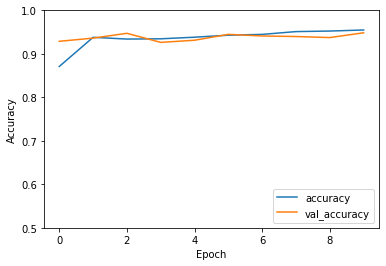

In [9]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

print(test_acc)